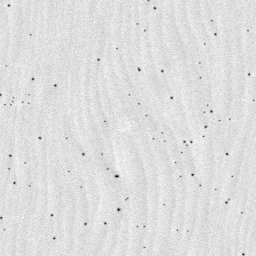

In [7]:
Image.open(input_path)

In [11]:
from PIL import Image
import numpy as np

input_path = './afm_data/jiawei/AIX6417A_3um_scan1_100pN_17gain_256_2um z range.0_00002.png'
output_path = './afm_data/jiawei/enhanced_output.png'

lower_percentile=0.5
upper_percentile=99.5


image = Image.open(input_path)
img_array = np.array(image).astype(float)

# Get percentiles
threshold = np.percentile(img_array, lower_percentile)
max_val = np.percentile(img_array, upper_percentile)

print(f"Lower threshold: {threshold}")
print(f"Upper threshold: {max_val}")

# Clip values outside the range
clipped = np.clip(img_array, threshold, max_val)

# Scale to 0-255
scaled = (clipped - threshold) / (max_val - threshold) * 255

# Convert to uint8
output_image = Image.fromarray(scaled.astype(np.uint8))

output_image.save(output_path)
print(f"Enhanced image saved to {output_path}")



# enhance_contrast_with_clipping('./afm_data/jiawei/AIX6417A_3um_scan1_100pN_17gain_256_2um z range.0_00002.png',
#                                './afm_data/jiawei/enhanced_output.png')


Lower threshold: 45692.425
Upper threshold: 62079.0
Enhanced image saved to ./afm_data/jiawei/enhanced_output.png


In [1]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk


In [1]:
from PIL import ImageOps
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk

# Convert the image to a format suitable for tkinter with afmhot colormap
image1_pil = Image.fromarray((plt.cm.afmhot(image)[:, :, :3] * 255).astype(np.uint8))

# Increase contrast by setting the brightest pixel to white and the darkest 10% of pixels to black
image1_pil = ImageOps.autocontrast(image1_pil, cutoff=10, preserve_tone=True)

image1_tk = ImageTk.PhotoImage(image1_pil)
canvas.create_image(0, 0, anchor=tk.NW, image=image1_tk)


NameError: name 'plt' is not defined

In [ ]:
from tkinter import filedialog
import os

# Prompt user to select a folder
folder_path = filedialog.askdirectory(title="Select Folder Containing PNG Files")

# Make a list of full filepaths for all PNG files in the selected folder
afm_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')]

print(f"Selected folder: {folder_path}")
print(f"AFM files: {afm_files}")

In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
from PIL import Image, ImageTk
import os
import cv2
import pandas as pd
from skimage import io
from skimage import filters, measure
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np


# Select folder containing the images
# Prompt user to select a folder
folder_path = filedialog.askdirectory(title="Select Folder Containing PNG Files")

# Make a list of full filepaths for all PNG files in the selected folder
afm_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')]

print(f"Selected folder: {folder_path}")
print(f"AFM files: {afm_files}")




# Function to update the counter label
def update_counter_label(manual=False):
    if manual:
        counter_label.config(text=f"Manual Categorisation. Click any undetected spots.")
    else:
        counter_label.config(text=f"Spot {current_spot_index + 1} of {total_spots}")

# Function to handle user clicks for undetected spots
def on_canvas_click(event):
    global spot_data, undo_stack
    x, y = event.x, event.y
    print(f"User clicked at ({x}, {y}).")

    # Create a pop-up window for categorisation
    popup = tk.Toplevel(root)
    popup.title("Categorise Spot")
    popup.geometry("300x150")

    label = tk.Label(popup, text=f"Categorise the spot at ({x}, {y}):", font=("Arial", 12))
    label.pack(pady=10)

    def categorise_new_spot(category):
        global spot_data, undo_stack
        print(f"Spot at ({x}, {y}) labeled as '{category}'.")
        # Add the new spot to the DataFrame
        spot_data = pd.concat([spot_data, pd.DataFrame({
            'x': [x],
            'y': [y],
            'size': [None],  # Size is unknown for manually added spots
            'category': [category]
        })], ignore_index=True)
        # Push the categorised spot onto the undo stack
        undo_stack.append(({'x': x, 'y': y}, category))
        # Save to CSV file
        spot_data.to_csv(csv_file_path, index=False)
        popup.destroy()

    # Buttons for categorisation
    large_button = ttk.Button(popup, text="Large", command=lambda: categorise_new_spot("large"))
    large_button.pack(side=tk.LEFT, padx=20, pady=20)

    small_button = ttk.Button(popup, text="Small", command=lambda: categorise_new_spot("small"))
    small_button.pack(side=tk.RIGHT, padx=20, pady=20)

# Function to highlight all spots
def highlight_all_spots():
    canvas.delete("highlight")
    for spot in spots_image1:
        x, y = spot.centroid[1], spot.centroid[0]
        canvas.create_oval(x-8, y-8, x+8, y+8, outline="yellow", width=2, tags="highlight")
    canvas.update()

# Function to finish the manual categorisation phase
def finish_manual_categorisation():
    print("Manual categorisation finished.")
    root.destroy()

# After all spots are categorised
def start_manual_categorisation():
    print("All spots have been categorised. Highlighting all spots.")
    update_counter_label(manual=True)
    highlight_all_spots()
    canvas.bind("<Button-1>", on_canvas_click)

    # Add a Finish button
    finish_button = ttk.Button(button_frame, text="Finish", command=finish_manual_categorisation)
    finish_button.pack(side=tk.LEFT, padx=5, pady=5)

# Modify the categorise_spot function to call start_manual_categorisation
def categorise_spot(category, spot, canvas, root):
    global spot_data, undo_stack, current_spot_index, first_spot, spots_iter
    if category == "skip":
        print('Skipping categorisation function for undo')
    elif category == "not_a_spot":
        print(f"Spot at ({spot.centroid[1]:.1f}, {spot.centroid[0]:.1f}) labeled as 'Not a Spot'.")
        undo_stack.append((spot, category))
    elif category == "combination":
        print(f"Spot at ({spot.centroid[1]:.1f}, {spot.centroid[0]:.1f}) labeled as 'Combination of Multiple Spots'.")
        spot_data = pd.concat([spot_data, pd.DataFrame({
            'x': [spot.centroid[1]],
            'y': [spot.centroid[0]],
            'size': [spot.area],
            'category': [category]
        })], ignore_index=True)
        undo_stack.append((spot, category))
    else:
        spot_data = pd.concat([spot_data, pd.DataFrame({
            'x': [spot.centroid[1]],
            'y': [spot.centroid[0]],
            'size': [spot.area],
            'category': [category]
        })], ignore_index=True)
        undo_stack.append((spot, category))
        print(f"Spot at ({spot.centroid[1]:.1f}, {spot.centroid[0]:.1f}) labeled as '{category}'.")

    spot_data.to_csv(csv_file_path, index=False)

    try:
        next_spot = next(spots_iter)
        first_spot = next_spot
        current_spot_index += 1
        update_counter_label()
        highlight_spot(next_spot, canvas)
    except StopIteration:
        start_manual_categorisation()

# Function to undo the last categorisation
def undo_last_action(canvas):
    global spot_data, undo_stack, current_spot_index, spots_iter
    if undo_stack:
        last_spot, last_category = undo_stack.pop()
        # Remove the last categorised spot from the DataFrame
        spot_data = spot_data[~((spot_data['x'] == last_spot.centroid[1]) & 
                                (spot_data['y'] == last_spot.centroid[0]) & 
                                (spot_data['category'] == last_category))]
        print(f"Undo: Removed spot at ({last_spot.centroid[1]:.1f}, {last_spot.centroid[0]:.1f}) labeled as '{last_category}'.")
        # Highlight the undone spot again
        highlight_spot(last_spot, canvas)
        # Re-add the undone spot to the iterator
        new_list = [last_spot] + list(spots_iter)
        print("New List: " + str(new_list))
        spots_iter = iter(new_list)
        current_spot_index -= 1
        update_counter_label()
        categorise_spot("skip", last_spot, canvas, root)
    else:
        print("Nothing to undo.")        


# Function to highlight a spot on the canvas
def highlight_spot(spot, canvas):
    canvas.delete("highlight")
    x, y = spot.centroid[1], spot.centroid[0]
    canvas.create_oval(x-8, y-8, x+8, y+8, outline="yellow", width=2, tags="highlight")
    canvas.update()



for idx, afm_file in enumerate(afm_files):

    # Define image
    # image = io.imread(afm_file, as_gray=True)
    image = cv2.imread(afm_file, cv2.IMREAD_GRAYSCALE)

    # Apply local thresholding to detect spots
    # Fit a plane to the image
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    A = np.c_[x.ravel(), y.ravel(), np.ones_like(x.ravel())]
    coeff, _, _, _ = np.linalg.lstsq(A, image.ravel(), rcond=None)
    plane = (coeff[0] * x + coeff[1] * y + coeff[2]).reshape(image.shape)

    # Set any pixel with a value higher than the plane to the level of the plane
    filtered_image = np.minimum(image, plane)

    # Apply the thresholding
    threshold_image = filters.threshold_local(filtered_image, block_size=19, offset=12)
    dark_spots_image = filtered_image < threshold_image

    # Label the dark spots
    labeled_spots, num_spots = ndi.label(dark_spots_image)

    # Filter to spots between 5 and 100 pixels
    spots = measure.regionprops(labeled_spots, intensity_image=image)
    spots_image1 = [spot for spot in spots if 5 <= spot.area <= 100]

    # Initialise a DataFrame to store categorised spots
    spot_data = pd.DataFrame(columns=['x', 'y', 'size', 'category'])

    # CSV file path to save categorised spots
    csv_file_path = afm_file.replace('.png', '_categorised.csv')

    # Stack to keep track of categorised spots for undo functionality
    undo_stack = []

    # Counter to track the current spot index
    current_spot_index = 0
    total_spots = len(spots_image1)

    # Create the main application window
    root = tk.Tk()
    root.title(f"Spot Categorisation - Image {idx + 1} of {len(afm_files)}")

    # Create a canvas to display the image
    canvas = tk.Canvas(root, width=image.shape[1], height=image.shape[0], bg="white")
    canvas.pack()

    # Convert the image to a format suitable for tkinter
    # image1_pil = Image.fromarray(image)
    image1_pil = Image.fromarray((plt.cm.afmhot(image)[:, :, :3] * 255).astype(np.uint8))
    image1_tk = ImageTk.PhotoImage(image1_pil)
    canvas.create_image(0, 0, anchor=tk.NW, image=image1_tk)

    # Create a frame for buttons
    button_frame = tk.Frame(root)
    button_frame.pack(side=tk.BOTTOM, fill=tk.X)

    # Create an iterator for the spots
    spots_iter = iter([spot for spot in spots_image1 if 5 <= spot.area <= 100])

    # Highlight the first spot
    try:
        global first_spot
        first_spot = next(spots_iter)
        highlight_spot(first_spot, canvas)
    except StopIteration:
        print("No spots to categorise.")
        # root.destroy()

    # Create a counter label
    counter_label = tk.Label(root, text=f"Spot 1 of {total_spots}", font=("Arial", 12))
    counter_label.pack()

    # Create buttons for categorisation
    categories = [('Large', 'large'),
                ('Small', 'small'),
                ('Not a Spot', 'not_a_spot'),
                ('Combination', 'combination')]
    for text, category in categories:
        button = ttk.Button(button_frame, text=text, command=lambda c=category: categorise_spot(c, first_spot, canvas, root))
        button.pack(side=tk.LEFT, padx=5, pady=5)
        button.pack(side=tk.LEFT, padx=5, pady=5)

    # Add an Undo button
    undo_button = ttk.Button(button_frame, text="Undo", command=lambda: undo_last_action(canvas))
    undo_button.pack(side=tk.LEFT, padx=5, pady=5)

    root.mainloop()


Selected folder: C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels
AFM files: ['C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_03.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_04.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_05.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_06.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_07.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_08.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_09.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_labels\\fat_end_outside_L_10.0_00000.png', 'C:/Users/cobia/OneDrive - University of Cambridge/Python/afm_l

C:\Users\cobia\AppData\Local\Temp\ipykernel_23768\2769145916.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spot_data = pd.concat([spot_data, pd.DataFrame({


Spot at (14.4, 27.5) labeled as 'large'.
Spot at (420.7, 29.7) labeled as 'large'.
Spot at (209.8, 36.5) labeled as 'small'.
Spot at (341.4, 39.4) labeled as 'large'.
Spot at (229.9, 42.4) labeled as 'large'.
Spot at (312.5, 44.8) labeled as 'large'.
Spot at (95.8, 45.3) labeled as 'small'.
Spot at (22.6, 57.2) labeled as 'large'.
Spot at (277.6, 56.9) labeled as 'small'.
Spot at (79.4, 59.8) labeled as 'large'.
Spot at (500.6, 63.3) labeled as 'large'.
Spot at (409.1, 98.7) labeled as 'large'.
Spot at (304.8, 107.1) labeled as 'large'.
Spot at (17.0, 125.8) labeled as 'small'.
Spot at (118.7, 140.9) labeled as 'large'.
Spot at (383.2, 143.9) labeled as 'small'.
Spot at (203.7, 148.9) labeled as 'large'.
Spot at (357.8, 151.9) labeled as 'large'.
Spot at (146.3, 169.6) labeled as 'large'.
Spot at (466.5, 183.7) labeled as 'large'.
Spot at (506.7, 191.3) labeled as 'small'.
Spot at (39.9, 194.6) labeled as 'large'.
Spot at (122.0, 196.6) labeled as 'large'.
Spot at (283.4, 216.7) labele

In [ ]:
# Convert the image to a format suitable for tkinter with afmhot colormap
image1_pil = Image.fromarray((plt.cm.afmhot(image)[:, :, :3] * 255).astype(np.uint8))
image1_tk = ImageTk.PhotoImage(image1_pil)
canvas.create_image(0, 0, anchor=tk.NW, image=image1_tk)

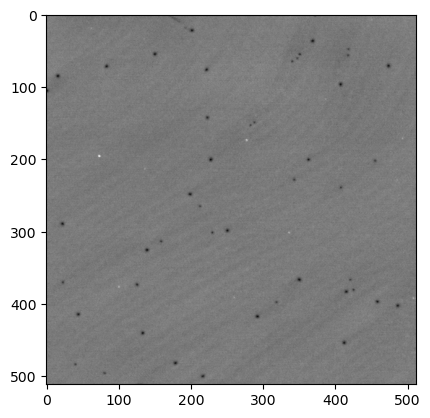

In [5]:
plt.imshow(image, cmap='gray')